In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import utils

In [98]:
color_pal = sns.color_palette()

## Reading in files and indexing them on time

In [99]:
targets_a = pd.read_parquet('../data/A/train_targets.parquet')
targets_b = pd.read_parquet('../data/B/train_targets.parquet')
targets_c = pd.read_parquet('../data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [100]:
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [101]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [102]:
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


## Some EDA

In [103]:
targets_a.describe()

,pv_measurement
count,34085.000000
mean,630.594707
std,1165.902422
min,0.000000
25%,0.000000
50%,5.940000
75%,678.040000
max,5733.420000


In [104]:
# Notice that missing rows are simply non-existent for targets_a, not filled with NaN or anything
# From 21. october
display(targets_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


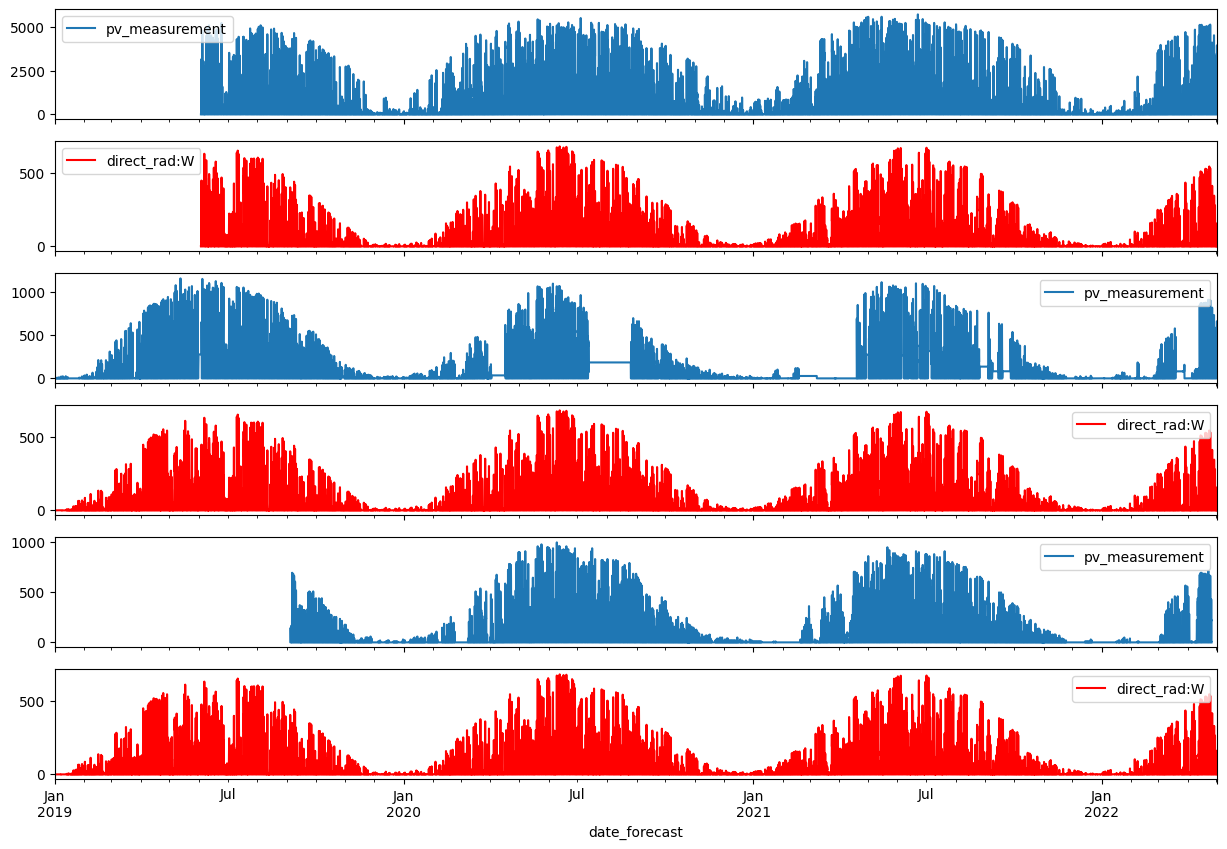

In [105]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

utils.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

## Data Preprocessing

34085 32848 32155
34085 26967 21684


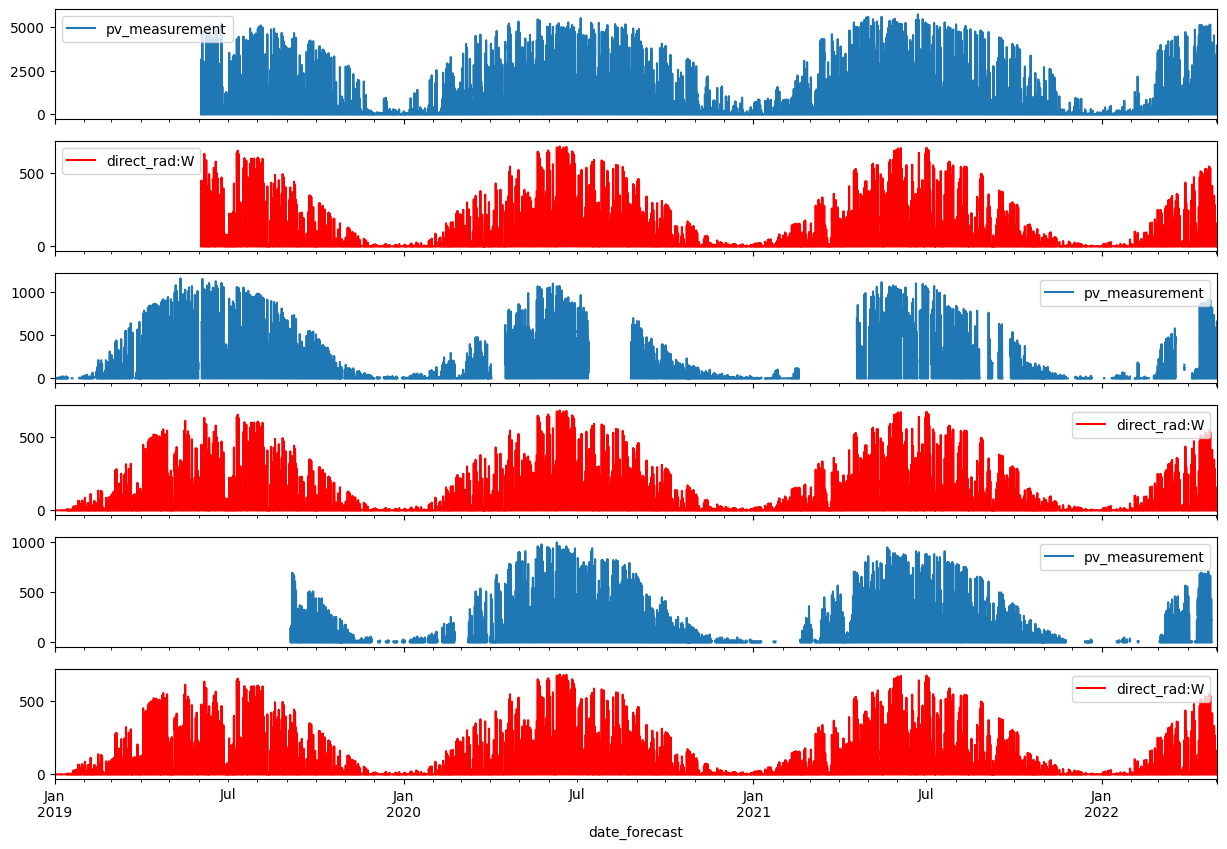

In [106]:
print(targets_a.size, targets_b.size, targets_c.size)

# removing rows where pv_measurment remains the same for more than 24 hours.
targets_a = utils.remove_constant_values(targets_a, "pv_measurement", 48).dropna()
targets_b = utils.remove_constant_values(targets_b, "pv_measurement", 48).dropna()
targets_c = utils.remove_constant_values(targets_c, "pv_measurement", 48).dropna()

print(targets_a.size, targets_b.size, targets_c.size)

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

utils.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [107]:
### Adding more time based features to the datasets
X_train_observed_a = utils.create_features(X_train_observed_a)
X_train_observed_b = utils.create_features(X_train_observed_b)
X_train_observed_c = utils.create_features(X_train_observed_c)

X_train_estimated_a = utils.create_features(X_train_estimated_a)
X_train_estimated_b = utils.create_features(X_train_estimated_b)
X_train_estimated_c = utils.create_features(X_train_estimated_c)

X_test_estimated_a = utils.create_features(X_test_estimated_a)
X_test_estimated_b = utils.create_features(X_test_estimated_b)
X_test_estimated_c = utils.create_features(X_test_estimated_c)

In [108]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)


In [109]:
# Check which features most correlated with y
correlations = train_a.corrwith(train_a["pv_measurement"])
for index, corr in correlations.items():
    correlations[index] = abs(corr)

sorted = correlations.sort_values(ascending=False)
best_features = list(sorted[1:10].index)
print(best_features)

['direct_rad:W', 'direct_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'diffuse_rad:W', 'sun_elevation:d', 'diffuse_rad_1h:J', 'is_in_shadow:idx', 'is_day:idx']


## Create our model

In [110]:
FEATURES = list(train_a.columns[:-1]) # Using all the features of X.
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]
X_b = train_b[FEATURES]
y_b = train_b[TARGETS]
X_c = train_c[FEATURES]
y_c = train_c[TARGETS]

### Location A

In [111]:
### Location A

### If using validation set, split the data into training and testing sets 
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_A.fit(X_train_a, y_train_a,
        eval_set = [(X_train_a, y_train_a), (X_test_a, y_test_a)],
        verbose=100)

# Make predictions on the test data
y_pred_a = reg_A.predict(X_test_a)

y_pred_a = np.clip(y_pred_a, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_a, y_pred_a)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:674.46778	validation_1-mae:645.74264
[100]	validation_0-mae:328.52551	validation_1-mae:317.49072
[200]	validation_0-mae:236.39783	validation_1-mae:230.24033
[300]	validation_0-mae:210.46095	validation_1-mae:207.00478
[400]	validation_0-mae:201.79901	validation_1-mae:199.09182
[500]	validation_0-mae:198.51422	validation_1-mae:196.74116
[600]	validation_0-mae:196.97031	validation_1-mae:195.79483
[700]	validation_0-mae:195.43669	validation_1-mae:194.77609
[800]	validation_0-mae:194.13523	validation_1-mae:194.04972
[900]	validation_0-mae:193.35205	validation_1-mae:193.65995
[999]	validation_0-mae:192.51716	validation_1-mae:193.21118
Mean Absolute Error: 193.1594832521518


### Location B

In [112]:
### Location B

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, shuffle=False)

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_B.fit(X_train_b, y_train_b,
        eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)],
        verbose=100)

# Make predictions on the test data
y_pred_b = reg_B.predict(X_test_b)

y_pred_b = np.clip(y_pred_b, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_b, y_pred_b)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:123.00484	validation_1-mae:62.19413
[100]	validation_0-mae:57.23867	validation_1-mae:30.58173
[200]	validation_0-mae:37.83747	validation_1-mae:23.67729
[300]	validation_0-mae:31.67941	validation_1-mae:22.39843
[400]	validation_0-mae:29.48946	validation_1-mae:22.08737
[500]	validation_0-mae:28.73224	validation_1-mae:22.06190
[600]	validation_0-mae:28.27762	validation_1-mae:22.04831
[645]	validation_0-mae:28.12140	validation_1-mae:22.05973
Mean Absolute Error: 22.038065702404875


### Location C

In [113]:
### Location C

# Split the data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, shuffle=False)

# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_C.fit(X_train_c, y_train_c,
        eval_set = [(X_train_c, y_train_c), (X_test_c, y_test_c)],
        verbose=100)

# Make predictions on the test data
y_pred_c = reg_C.predict(X_test_c)

y_pred_c = np.clip(y_pred_c, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_c, y_pred_c)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:111.54768	validation_1-mae:60.07927
[100]	validation_0-mae:53.69114	validation_1-mae:27.32192
[200]	validation_0-mae:34.86985	validation_1-mae:19.64158
[300]	validation_0-mae:29.00380	validation_1-mae:17.78170
[400]	validation_0-mae:27.10370	validation_1-mae:17.32524
[500]	validation_0-mae:26.29178	validation_1-mae:17.10752
[600]	validation_0-mae:25.77044	validation_1-mae:17.00813
[700]	validation_0-mae:25.47504	validation_1-mae:16.97335
[800]	validation_0-mae:25.15047	validation_1-mae:16.93212
[856]	validation_0-mae:24.99647	validation_1-mae:16.93260
Mean Absolute Error: 16.890406741691752


## Analysis

2023-04-28 11:00:00    3277.960078
2023-04-28 12:00:00    2869.155664
2023-03-23 13:00:00    2752.603301
2023-04-28 10:00:00    2708.667695
2023-04-08 11:00:00    2628.673804
2023-04-30 12:00:00    2572.189419
2023-03-20 11:00:00    2511.301074
2023-04-08 12:00:00    2468.361685
2023-04-04 08:00:00    2323.400430
2023-04-14 09:00:00    2256.292974
Name: error, dtype: float64

Mean Absolute Error: 114.87408741064351


<Axes: >

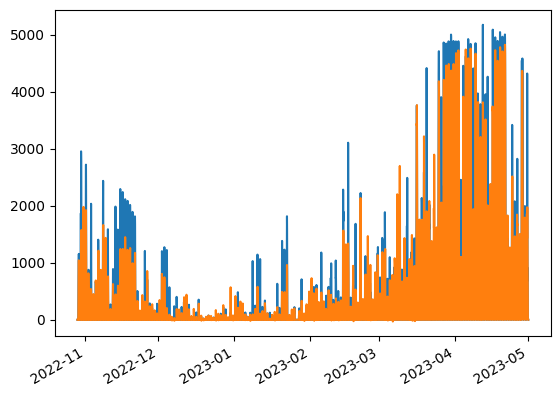

In [119]:
df = X_train_estimated_a[FEATURES]
df["prediction"] = reg_A.predict(X_train_estimated_a[FEATURES])

df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head(10))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

df["pv_measurement"].plot()
df["prediction"].plot() 

2023-04-28 11:00:00    604.277062
2023-04-28 12:00:00    577.771494
2023-04-30 12:00:00    522.333818
2023-04-08 11:00:00    492.360413
2023-04-28 10:00:00    467.262148
2023-04-14 09:00:00    418.074589
2023-04-19 09:00:00    395.246287
2023-04-08 12:00:00    386.060332
2023-03-16 12:00:00    362.619012
2023-04-30 13:00:00    357.528155
Name: error, dtype: float64

Mean Absolute Error: 16.492555432785576


<Axes: >

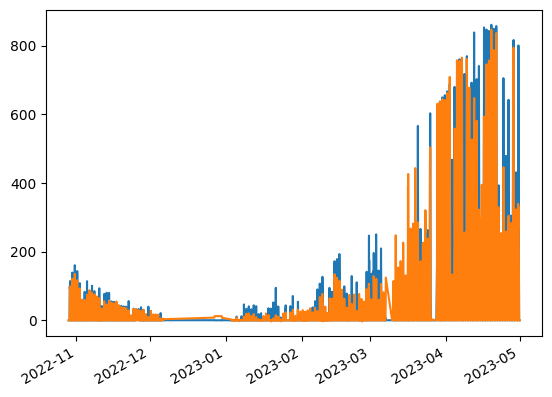

In [120]:
df = X_train_estimated_b[FEATURES]
df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES])

df = pd.merge(df, targets_b, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head(10))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

df["pv_measurement"].plot()
df["prediction"].plot()

2023-03-19 10:00:00    362.358651
2023-04-28 11:00:00    337.074563
2023-04-14 11:00:00    329.281024
2023-04-28 14:00:00    325.774028
2023-04-28 13:00:00    293.271963
2023-04-07 09:00:00    288.926526
2023-04-28 10:00:00    283.392158
2023-04-24 09:00:00    279.165231
2023-04-28 16:00:00    271.704337
2023-04-28 12:00:00    270.336794
Name: error, dtype: float64

Mean Absolute Error: 18.132487708504478


<Axes: >

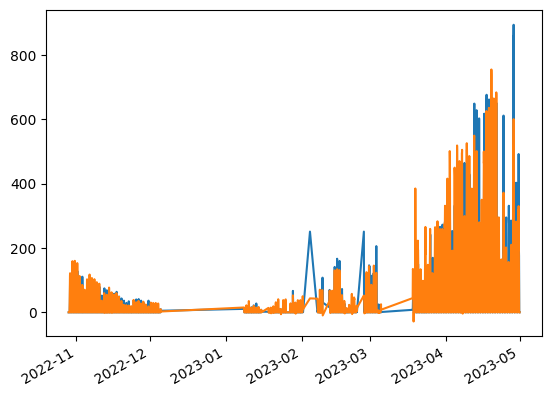

In [123]:
df = X_train_estimated_c[FEATURES]
df["prediction"] = reg_C.predict(X_train_estimated_c[FEATURES])

df = pd.merge(df, targets_c, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head(10))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

df["pv_measurement"].plot()
df["prediction"].plot()


## Predicting on the actual test set

In [115]:
### Location B
A_pred = reg_A.predict(X_test_estimated_a[FEATURES])
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])
    

In [116]:
### Location B
B_pred = reg_B.predict(X_test_estimated_b[FEATURES])
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

In [117]:
   
### Location C
C_pred = reg_C.predict(X_test_estimated_c[FEATURES])
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

## Storing the predictions

In [118]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
# remove negative predictions
predictions = np.clip(predictions, a_min=0, a_max=None)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("saves/xgboost5.csv", index=False)